# Compare sector-based sea ice area (SIA) between model output and satellite (NSIDC) data

This script demonstrates how to load, calculate and slice SIA into different regions of interest for model output and NSIDC data, and then to plot both together for easy comparison.

The user first enters some information to customise the analysis.

In [1]:
# Enter required start and end years 
start_year = 1979
end_year   = 2018

# Enter experiment name
experiment = '025deg_jra55_iaf_omip2_cycle6'

Sector definitions are based on Raphael & Hobbs (2014). The sectors are given individual sector names, minimum longitude, and maximum longitude (in units of degrees east).

In [2]:
sectors = {
          'Circumpolar' : {'min_lon' : 0., 'max_lon' : 360.},
          'Weddell Sea' : {'min_lon' : 293., 'max_lon' : 346.},
          'King Haakon VII Sea' : {'min_lon' : 346., 'max_lon' : 71.},
          'East Antarctica' : {'min_lon' : 71., 'max_lon' : 163.},
          'Ross Sea' : {'min_lon' : 163., 'max_lon' : 210.},
          'Amundsen/Bellingshausen Sea' : {'min_lon' : 210., 'max_lon' : 293.},
        } 

First, based on the user-specified variables listed above, the arguments to search the database access are set up, ready to be passed to the cookbook querying tools.

In [3]:
model_args = {
              'expt' : experiment,
              'variable' : 'aice_m', # Ice area fraction 
              'frequency' : '1 monthly', # Using monthly data 
              'start_time' : str(start_year)+'-02-01', # Loading 'February' instead of 'January' due to time offset (see below)
              'end_time' : str(int(end_year)+1)+'-01-01' # Loading the first month of the following year due to time offset (see below)
             }

The cookbook must be loaded in order to access the data through the cookbook, alongside various other libraries.

In [4]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import cf_xarray as cf
import pandas as pd
from datetime import timedelta

# Import various plotting libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import geocat.viz as gv

Next, a dask client is started.

In [5]:
from dask.distributed import Client
client=Client

# Load and prepare ACCESS-OM2 model output 

To connect to the database and obtain ACCESS data, a default database session is created.

In [6]:
session = cc.database.create_session()

Model data is obtained using the COSIMA cookbook.

In [7]:
OM2_SIC = cc.querying.getvar(session=session, **model_args)

The data timestep is also corrected (since the CICE5 timestamp is midnight on the last day of the month, xarray interprets this to mean the start of the following month). Instead, subtracting 15 days from the timestep roughly offsets the timestamp to the middle of the month.

In [8]:
OM2_SIC['time'] = OM2_SIC.time.to_pandas() - timedelta(days=15)

Now the sea ice area fraction data is read: 

In [9]:
OM2_area = cc.querying.getvar(session=session, variable = 'tarea', expt= model_args['expt'], frequency='1 monthly', n=1)

Spatial coordinates are loaded for area selection - since model_data is a dask array (not an xarray Dataset), these must be loaded prior.

In [10]:
OM2_lat = OM2_SIC.cf['latitude'].compute()
OM2_lon = OM2_SIC.cf['longitude'].compute()
OM2_spatial_dims = OM2_SIC.dims[1:] # Note the names of the spatial dimensions for later 

To reduce to only the high-latitudes of the Southern Ocean, anything north of 50 S is masked out.
Note: CICE output files do not have 1D coordinates (e.g. xt_ocean) attached so the .cf.sel() method won't work; .where() is used instead. 

In [11]:
# Mask model data
OM2_SIC = OM2_SIC.where(OM2_lat < -50, drop=True)

# Mask sea ice concentration variable 
OM2_area = OM2_area.where(OM2_lat < -50, drop=True)

# Mask longitude array 
OM2_lon = OM2_lon.where(OM2_lat < -50, drop=True)  

To match the NSIDC data, model data units are converted to km^2 (and NaN values replaced with zeroes in the process).

In [12]:
OM2_SIC = OM2_SIC.fillna(0) * 1.e-6

# Load and prepare NSIDC Climate Data Record 

Observations are loaded directly through PolarWatch:

In [13]:
# Set path to NSIDC data  
CDR_path = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday"

# Obtain data, change spatial dimension names to match future lat/lon grids 
CDR_SIC = xr.open_dataset(CDR_path).rename({'xgrid':'x','ygrid':'y'})

# Extract required variable and timespan
CDR_SIC = CDR_SIC.cdr_seaice_conc_monthly.sel(time=slice(str(start_year)+'-01-01', str(end_year)+'-12-31'), drop=True)

# Remove flagged data (masks etc) and return NaN values instead
CDR_SIC = CDR_SIC.where(CDR_SIC <= 1)

Both the lat/lon grid and the grid that denotes the area of each pixel are stored in separate files which must be downloaded separately:

In [14]:
!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat

File ‘pss25area_v3.dat’ already there; not retrieving.


In [15]:
!wget -nc https://noaadata.apps.nsidc.org/NOAA/G02202_V4/ancillary/G02202-cdr-ancillary-sh.nc

File ‘G02202-cdr-ancillary-sh.nc’ already there; not retrieving.



Now, the CDR 'area' dataset can be opened and used. Note: the array is in binary format and stored as 4-byte integers scaled by 1000 (therefore we divide by 1000 to convert units to km^2).

In [16]:
CDR_area = np.fromfile("pss25area_v3.dat", dtype=np.int32).reshape(
        CDR_SIC.isel(time=0).shape
        )

# Scale to km^2
CDR_area = CDR_area / 1000

# Attach coordinate variables
CDR_area = xr.DataArray(CDR_area, dims=['y','x'])

Next, the CDR lat/lon grid can be opened. Note that the longitude array spans -179.5:179.5, so we adjust the degrees to span 0:359 instead.

In [17]:
CDR_latlon = xr.open_dataset("G02202-cdr-ancillary-sh.nc")
CDR_lat = CDR_latlon["latitude"]
CDR_lon = CDR_latlon["longitude"]

# Convert longitude units where values are below zero
CDR_lon = xr.where(CDR_lon < 0, CDR_lon + 360, CDR_lon)

# Note the names of the spatial dimensions for later 
CDR_spatial_dims = CDR_SIC.dims[1:] 

As with model data, anything north of 50 S is masked out for CDR data.

In [18]:
# Mask model data
CDR_SIC = CDR_SIC.where(CDR_lat < -50, drop=True)

# Mask sea ice concentration variable 
CDR_area = CDR_area.where(CDR_lat < -50, drop=True)

# Mask longitude array 
CDR_lon = CDR_lon.where(CDR_lat < -50, drop=True)  

# Calculate SIA and slice into defined sea ice sectors

Now sea ice concentration is converted to sea ice area.

In [19]:
CDR_SIA = CDR_SIC * CDR_area
OM2_SIA = OM2_SIC * OM2_area

Calculate the spatial sum over each sea ice sector.

In [20]:
# Create output variables for attaching data 
CDR_SIA_sectors = []
OM2_SIA_sectors = []  

for sector_ix in sectors:
    xmin = sectors[sector_ix]['min_lon']
    xmax = sectors[sector_ix]['max_lon']

    if xmin < xmax:
        CDR_tmp = CDR_SIA.where((CDR_lon > xmin) & (CDR_lon <= xmax ))
        OM2_tmp = OM2_SIA.where((OM2_lon > xmin) & (OM2_lon <= xmax ))
    else:
        # Exception for when sector boundaries cross the longitude pivot point
        CDR_tmp = CDR_SIA.where((CDR_lon > xmin) | (CDR_lon <= xmax ))
        OM2_tmp = OM2_SIA.where((OM2_lon > xmin) | (OM2_lon <= xmax ))

    # Sum over spatial dimension 
    CDR_SIA_sectors.append((CDR_tmp.sum(CDR_spatial_dims)) * 1e-6)
    OM2_SIA_sectors.append((OM2_tmp.sum(OM2_spatial_dims)) * 1e-6)

# Convert from dask array to a xarray DataArray with coordinate information 
CDR_SIA_sectors = xr.DataArray(CDR_SIA_sectors,dims=["sector","time"],coords=[list(sectors.keys()),CDR_SIC.coords["time"].values])
OM2_SIA_sectors = xr.DataArray(OM2_SIA_sectors,dims=["sector","time"],coords=[list(sectors.keys()),OM2_SIC.coords["time"].values])

The seasonal evolution of SIA is calculated before the plotting variables:

In [21]:
# Create empty array so there will be a full dataset with correct dimensionality 
CDR_dSIA_sectors = xr.full_like(CDR_SIA_sectors, np.nan)
OM2_dSIA_sectors = xr.full_like(OM2_SIA_sectors, np.nan)

# Attach data to all but the first timestep
CDR_dSIA_sectors[:,1:] = CDR_SIA_sectors.diff("time")
OM2_dSIA_sectors[:,1:] = OM2_SIA_sectors.diff("time")

In [189]:
CDR_SIA_sectors

<xarray.DataArray (sector: 6, time: 480)> Size: 23kB
array([[ 3.87630272,  2.36305861,  2.99530354, ..., 15.51557481,
        12.47965503,  6.49376633],
       [ 1.50540953,  0.99962368,  1.34211159, ...,  3.22801134,
         2.80866957,  1.83069975],
       [ 0.33937562,  0.15415604,  0.18830246, ...,  4.86834914,
         3.87385241,  1.40558756],
       [ 0.56261649,  0.39634662,  0.51591164, ...,  2.2619835 ,
         1.42674678,  0.7122237 ],
       [ 0.25031208,  0.04471613,  0.21258498, ...,  2.39943162,
         2.04442602,  1.14056105],
       [ 1.21858899,  0.76821613,  0.73639288, ...,  2.75779921,
         2.32596025,  1.40469427]])
Coordinates:
  * sector   (sector) <U27 648B 'Circumpolar' ... 'Amundsen/Bellingshausen Sea'
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2018-12-01

Some timesteps in the NSIDC Climate Data Record are missing due to satellite problems, so we need to remove this data and make it NaN.

In [199]:
# Missing data array 
missing_data = ["1987-12-01", "1988-01-01"]

# Mask by missing data array 
CDR_SIA_sectors.loc[dict(time=missing_data)] = "nan"
CDR_SIA_sectors.loc[dict(time=missing_data)] = "nan"

Now, plotting variables can be calculated for each sector. As an example, the climatology, annual min/max/mean, and monthly anomalies are produced here.

In [200]:
# Calculate climatology
CDR_SIA_clm = CDR_SIA_sectors.groupby('time.month').mean('time')
OM2_SIA_clm = OM2_SIA_sectors.groupby('time.month').mean('time')

CDR_dSIA_clm = CDR_dSIA_sectors.groupby('time.month').mean('time')
OM2_dSIA_clm = OM2_dSIA_sectors.groupby('time.month').mean('time')

# Calculate annual minimums 
CDR_SIA_min = CDR_SIA_sectors.groupby('time.year').min('time')
OM2_SIA_min = OM2_SIA_sectors.groupby('time.year').min('time')

# Calculate annual maximums
CDR_SIA_max = CDR_SIA_sectors.groupby('time.year').max('time')
OM2_SIA_max = OM2_SIA_sectors.groupby('time.year').max('time')

# Calculate annual means 
CDR_SIA_mean = CDR_SIA_sectors.groupby('time.year').mean('time')
OM2_SIA_mean = OM2_SIA_sectors.groupby('time.year').mean('time')

# Calculate monthly anomalies 
CDR_SIA_anoms = CDR_SIA_sectors.groupby('time.month') - CDR_SIA_clm
OM2_SIA_anoms = OM2_SIA_sectors.groupby('time.month') - OM2_SIA_clm

# Plot variables 

In order to eliminate a whole lot of duplicate lines, a function is created to adjust the plots according to type. First, the climatological plots are created.

In [201]:
# Function to replicate common axes across multiple climatological plots 
def set_axes(ax, title, x_limits, x_step, y_limits, x_labels): # Personalise title and y axis limits per plot

    # Use geocat.viz function to set axes parameters
    gv.set_titles_and_labels(ax,
                             maintitle=title,
                             maintitlefontsize=12,
                             ylabel="10$^{6}$ km$^{2}$",
                             labelfontsize=10)
    gv.set_axes_limits_and_ticks(ax,
                                 xlim=x_limits,
                                 ylim=y_limits,
                                 xticks=np.arange(x_limits[0],x_limits[1]+1,step=x_step),
                                 xticklabels=x_labels[::x_step])
    ax.set_xticklabels(x_labels[::x_step],rotation=90,fontsize=10)

    # Assign parameters and return 
    return ax

This version of the climatological SIA plots compares the different sectors to each other for each dataset separately:

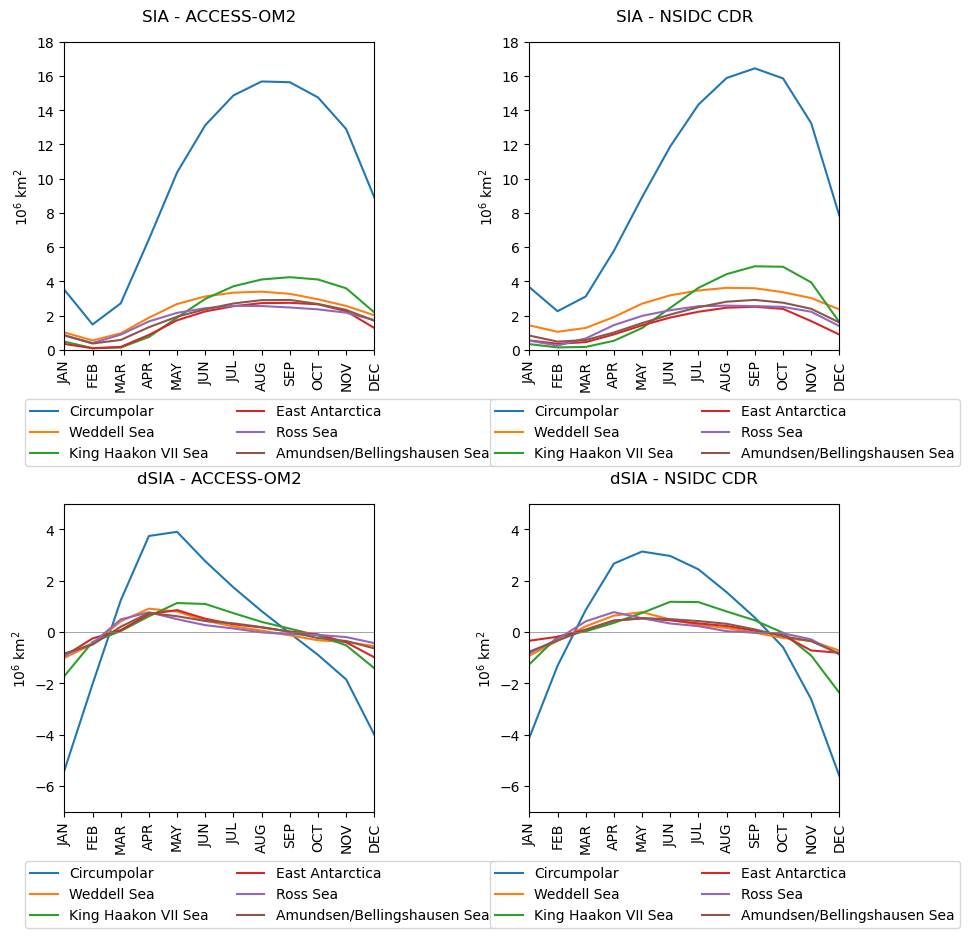

In [202]:
# Create months list for X axis titles 
month_list = ("JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC")

# Create subplots 
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(10, 10),
                         gridspec_kw=dict(wspace=0.5, hspace=0.5))

# Create subplot 1: ACCESS-OM2 SIA
axes[0,0] = set_axes(axes[0,0], "SIA - ACCESS-OM2", (0,11), 1, (0,18), month_list)
for ix in range(len(sectors)):
    axes[0][0].plot(OM2_SIA_clm[ix,:], label=list(sectors.keys())[ix])
axes[0,0].legend(loc='lower left', bbox_to_anchor=(-0.15, -0.4),ncol=2)
                             
# Create subplot 2: NSIDC CDR SIA
axes[0,1] = set_axes(axes[0,1], "SIA - NSIDC CDR", (0,11), 1, (0,18), month_list)
for ix in range(len(sectors)):
    axes[0][1].plot(CDR_SIA_clm[ix,:], label=list(sectors.keys())[ix])
axes[0,1].legend(loc='lower left', bbox_to_anchor=(-0.15, -0.4),ncol=2)

# Create subplot 3: ACCESS-OM2 dSIA
axes[1,0] = set_axes(axes[1,0], "dSIA - ACCESS-OM2", (0,11), 1, (-7,5), month_list)
for ix in range(len(sectors)):
    axes[1][0].plot(OM2_dSIA_clm[ix,:], label=list(sectors.keys())[ix])
axes[1,0].legend(loc='lower left', bbox_to_anchor=(-0.15, -0.4),ncol=2)
# Add zero line 
axes[1,0].plot((0,12),(0.0,0.0), linestyle='-', color="grey", linewidth=0.5)    
                             
# Create subplot 4: NSIDC CDR dSIA
axes[1,1] = set_axes(axes[1,1], "dSIA - NSIDC CDR", (0,11), 1, (-7,5), month_list)
for ix in range(len(sectors)):
    axes[1][1].plot(CDR_dSIA_clm[ix,:], label=list(sectors.keys())[ix])
axes[1,1].legend(loc='lower left', bbox_to_anchor=(-0.15, -0.4),ncol=2)
# Add zero line 
axes[1,1].plot((0,12),(0.0,0.0), linestyle='-', color="grey", linewidth=0.5)    

This version separates the sectors and plots the model and obs data together for each so they can easily be compared: 

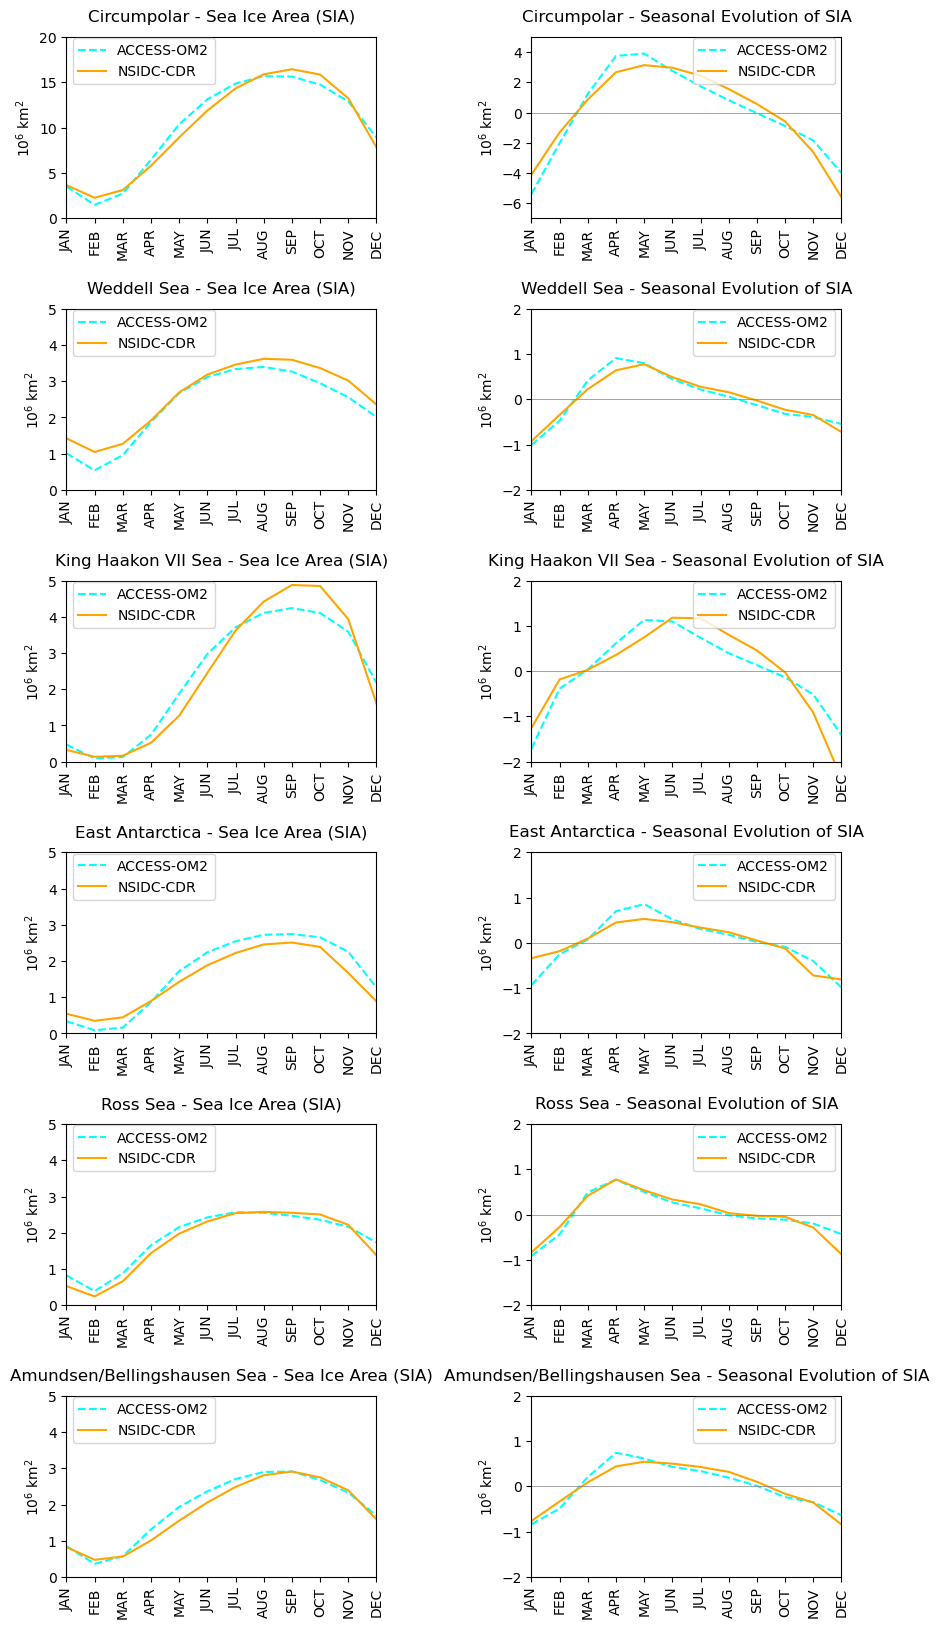

In [203]:
# Set separate line styles 
line_model = "--"
line_obs = "-"

# Create subplots 
fig, axes = plt.subplots(nrows=len(sectors),
                         ncols=2,
                         figsize=(10, 20),
                         gridspec_kw=dict(wspace=0.5, hspace=0.5))

for plot_ix in np.arange(len(sectors)):

    ##########
    #   SIA  #
    ##########
    
    # Set limits to be different for circumpolar vs regional plots 
    if plot_ix == 0:
        min_ix = 0
        max_ix = 20
    else:
        min_ix = 0
        max_ix = 5
    
    # Add common axes using function defined above [arguments = (ax, title, x_limits, x_step, y_limits, x_labels)]
    axes[plot_ix,0] = set_axes(axes[plot_ix,0], list(sectors.keys())[plot_ix] + " - Sea Ice Area (SIA)", (0,11), 1, (min_ix,max_ix), month_list)

    # Add data 
    axes[plot_ix,0].plot(OM2_SIA_clm[plot_ix,:], linestyle=line_model, color="cyan", label="ACCESS-OM2") 
    axes[plot_ix,0].plot(CDR_SIA_clm[plot_ix,:], linestyle=line_obs, color="orange", label="NSIDC-CDR") 

    # Add legend 
    axes[plot_ix,0].legend(loc='lower center', bbox_to_anchor=(0.25, 0.7))

    ############
    #   dSIA   #
    ############
    
    # Set limits to be different for circumpolar vs regional plots 
    if plot_ix == 0:
        min_ix = -7
        max_ix = 5
    else:
        min_ix = -2
        max_ix = 2
    
    # Add common axes using function defined above    
    axes[plot_ix,1] = set_axes(axes[plot_ix,1], list(sectors.keys())[plot_ix] + " - Seasonal Evolution of SIA", (0,11), 1, (min_ix,max_ix), month_list)

    # Add data     
    axes[plot_ix,1].plot(OM2_dSIA_clm[plot_ix,:], linestyle=line_model, color="cyan", label="ACCESS-OM2") 
    axes[plot_ix,1].plot(CDR_dSIA_clm[plot_ix,:], linestyle=line_obs, color="orange", label="NSIDC-CDR") 

    # Add zero line 
    axes[plot_ix,1].plot((0,12),(0.0,0.0), linestyle='-', color="grey", linewidth=0.5)    

    # Add legend 
    axes[plot_ix,1].legend(loc='lower center', bbox_to_anchor=(0.75, 0.7))

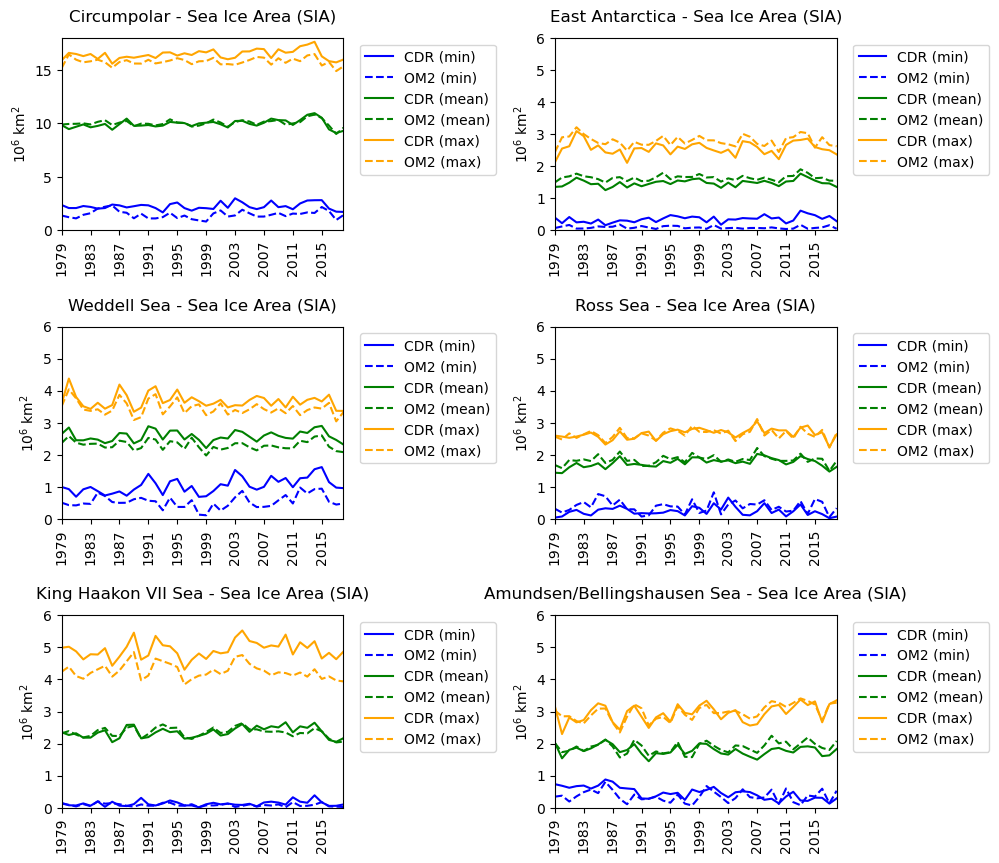

In [204]:
# Set line colours
colour_min = "blue"
colour_mean = "green"
colour_max = "orange"

# Set year array 
year_array = np.arange(min(OM2_SIA_mean.year),max(OM2_SIA_mean.year))

# Create subplots 
fig, axes = plt.subplots(nrows=3,
                         ncols=2,
                         figsize=(10, 10),
                         gridspec_kw=dict(wspace=0.75, hspace=0.5))

count = 0 
for col_ix in range(2):
    for row_ix in range(3):
        
        # Set limits to be different for circumpolar vs regional plots 
        if (row_ix == 0) & (col_ix == 0):
            min_ix = 0
            max_ix = 18
        else:
            min_ix = 0
            max_ix = 6
          
        # Add common axes using function defined above [arguments = (ax, title, x_limits, x_step, y_limits, x_labels)]
        axes[row_ix,col_ix] = set_axes(axes[row_ix,col_ix], list(sectors.keys())[count] + " - Sea Ice Area (SIA)", (0,len(year_array)), 4, (min_ix,max_ix), year_array)

        # Add data 
        axes[row_ix,col_ix].plot(CDR_SIA_min[count,:], linestyle=line_obs, color=colour_min, label="CDR (min)")
        axes[row_ix,col_ix].plot(OM2_SIA_min[count,:], linestyle=line_model, color=colour_min, label="OM2 (min)")
        axes[row_ix,col_ix].plot(CDR_SIA_mean[count,:], linestyle=line_obs, color=colour_mean, label="CDR (mean)")
        axes[row_ix,col_ix].plot(OM2_SIA_mean[count,:], linestyle=line_model, color=colour_mean, label="OM2 (mean)")
        axes[row_ix,col_ix].plot(CDR_SIA_max[count,:], linestyle=line_obs, color=colour_max, label="CDR (max)")
        axes[row_ix,col_ix].plot(OM2_SIA_max[count,:], linestyle=line_model, color=colour_max, label="OM2 (max)")

        # Add legend 
        axes[row_ix,col_ix].legend(loc='upper center', bbox_to_anchor=(1.3, 1.),ncol=1)

        # Increment count to move to next panel 
        count = count + 1

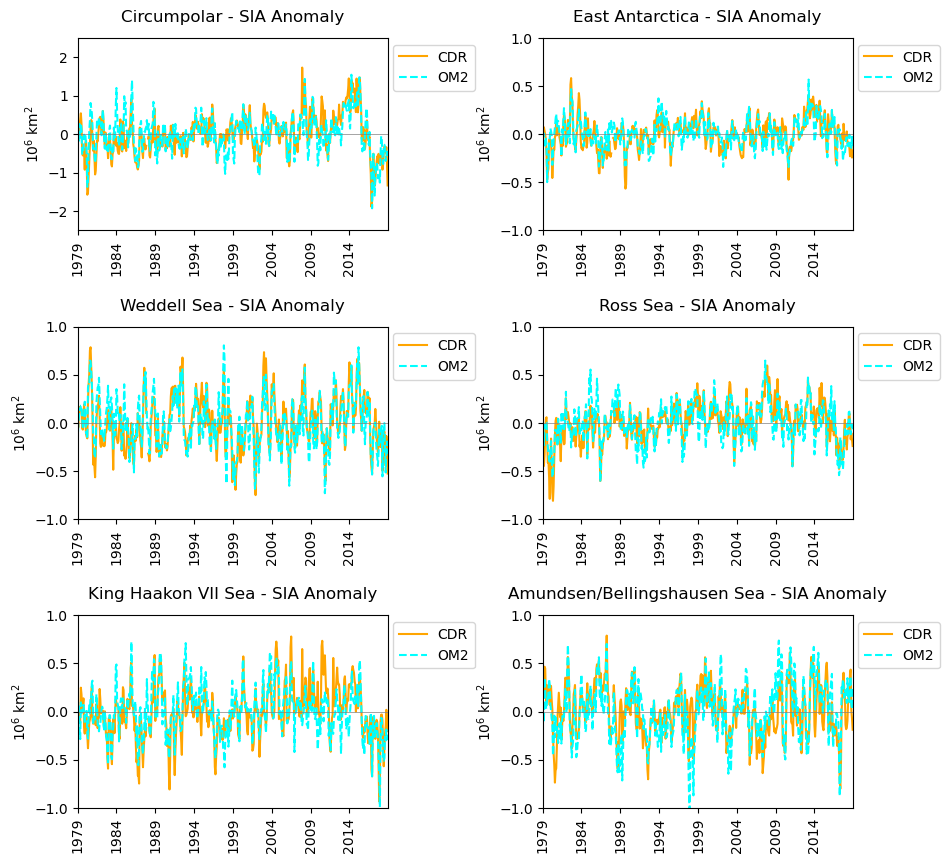

In [205]:
# Create subplots 
fig, axes = plt.subplots(nrows=3,
                         ncols=2,
                         figsize=(10, 10),
                         gridspec_kw=dict(wspace=0.5, hspace=0.5))

# Create labels 
labels = OM2_SIA_anoms.time.dt.year.drop_vars(("time","month")).data

count = 0 
for col_ix in range(2):
    for row_ix in range(3):

        # Set limits to be different for circumpolar vs regional plots 
        if (row_ix == 0) & (col_ix == 0):
            min_ix = -2.5
            max_ix = 2.5
        else:
            min_ix = -1
            max_ix = 1
        
        # Add common axes using function defined above [arguments = (ax, title, x_limits, x_step, y_limits, x_labels)]
        axes[row_ix,col_ix] = set_axes(axes[row_ix,col_ix], list(sectors.keys())[count] + " - SIA Anomaly", (0,len(OM2_SIA_anoms.time)-1), 60, (min_ix,max_ix), labels)
        
        # Add data 
        axes[row_ix,col_ix].plot(CDR_SIA_anoms[count,:], linestyle=line_obs, color="orange", label="CDR")
        axes[row_ix,col_ix].plot(OM2_SIA_anoms[count,:], linestyle=line_model, color="cyan", label="OM2")

        # Add zero line 
        axes[row_ix,col_ix].plot((0,len(OM2_SIA_anoms.time)),(0.0,0.0), linestyle='-', color="grey", linewidth=0.5)
        
        # Add legend 
        axes[row_ix,col_ix].legend(loc='upper center', bbox_to_anchor=(1.15, 1.),ncol=1)

        # Increment count to move to the next panel        
        count = count + 1